<a href="https://colab.research.google.com/github/Denniskag/Computer-vision-exam/blob/main/Research_Gap_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, skip_rate=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.skip_rate = skip_rate

    def _process_frame(self, frame):

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        equalized_frame = cv2.equalizeHist(gray_frame)

        processed_frame = cv2.cvtColor(equalized_frame, cv2.COLOR_GRAY2RGB)
        return processed_frame

    def _flow_index(self, *args, **kwargs):
        for index in super()._flow_index(*args, **kwargs):
            if index % self.skip_rate == 0:
                yield index

    def __getitem__(self, idx):
        batch_x, batch_y = super().__getitem__(idx)
        processed_batch_x = np.array([self._process_frame(frame) for frame in batch_x])
        return processed_batch_x, batch_y



In [3]:

train_datagen = CustomImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         skip_rate=2)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Computer vision datasets/data_A/train',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Computer vision datasets/data_A/test',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary')

Found 5638 images belonging to 2 classes.
Found 1408 images belonging to 2 classes.


In [4]:
def oversample_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        img, label = generator.next()
        X.append(img)
        y.append(label)
    X = np.vstack(X)
    y = np.hstack(y)
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X.reshape(len(X), -1), y)
    X_resampled = X_resampled.reshape(-1, 64, 64, 3)
    return X_resampled, y_resampled

In [5]:
X_resampled, y_resampled = oversample_data(training_set)


original_class_counts = Counter(training_set.classes)
resampled_class_counts = Counter(y_resampled)

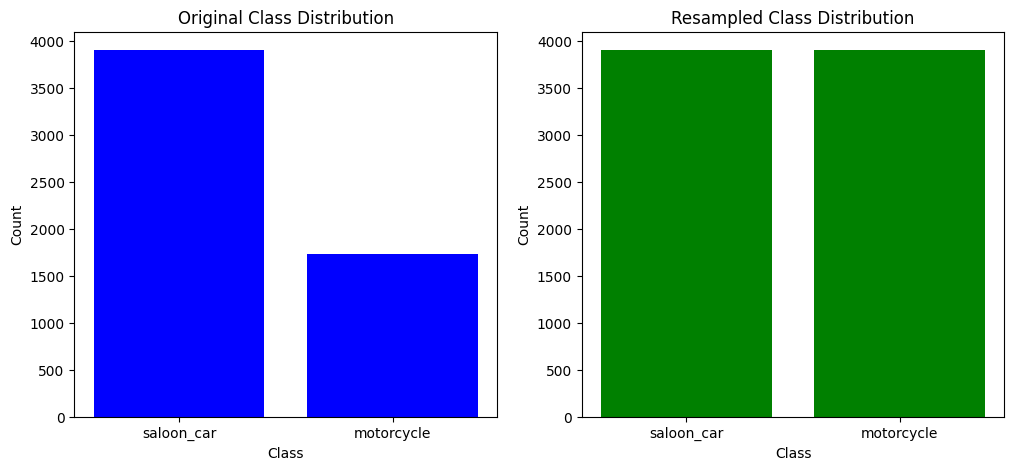

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(original_class_counts.keys(), original_class_counts.values(), color='blue')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['saloon_car', 'motorcycle'])
plt.subplot(1, 2, 2)
plt.bar(resampled_class_counts.keys(), resampled_class_counts.values(), color='green')
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['saloon_car', 'motorcycle'])
plt.show()

In [7]:
balanced_train_datagen = ImageDataGenerator(rescale=1./255)
balanced_training_set = balanced_train_datagen.flow(X_resampled, y_resampled, batch_size=32)

In [8]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn.fit(x=training_set, validation_data=test_set, epochs=2)

Epoch 1/2
177/177 [==============================] - 565s 3s/step - loss: 0.2974 - accuracy: 0.8709 - val_loss: 0.1932 - val_accuracy: 0.9425
Epoch 2/2
177/177 [==============================] - 30s 171ms/step - loss: 0.1392 - accuracy: 0.9564 - val_loss: 0.1196 - val_accuracy: 0.9673


In [9]:
cnn.save('/path/to/saved_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
cnn_balanced = tf.keras.models.Sequential()
cnn_balanced.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn_balanced.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn_balanced.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn_balanced.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn_balanced.add(tf.keras.layers.Flatten())
cnn_balanced.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn_balanced.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_balanced.fit(x=balanced_training_set, validation_data=test_set, epochs=2)

Epoch 1/2
245/245 [==============================] - 8s 27ms/step - loss: 0.3910 - accuracy: 0.8150 - val_loss: 599.5662 - val_accuracy: 0.3281
Epoch 2/2
245/245 [==============================] - 6s 26ms/step - loss: 0.1670 - accuracy: 0.9424 - val_loss: 803.9401 - val_accuracy: 0.3274


In [11]:
cnn_balanced.save('/path/to/saved_balanced_model.h6')

In [12]:
test_set.reset()
predictions_original = cnn.predict(test_set)
predicted_classes_original = (predictions_original > 0.5).astype(int).reshape(-1)
true_classes = test_set.classes

predictions_balanced = cnn_balanced.predict(test_set)
predicted_classes_balanced = (predictions_balanced > 0.5).astype(int).reshape(-1)

44/44 [==============================] - 5s 104ms/step


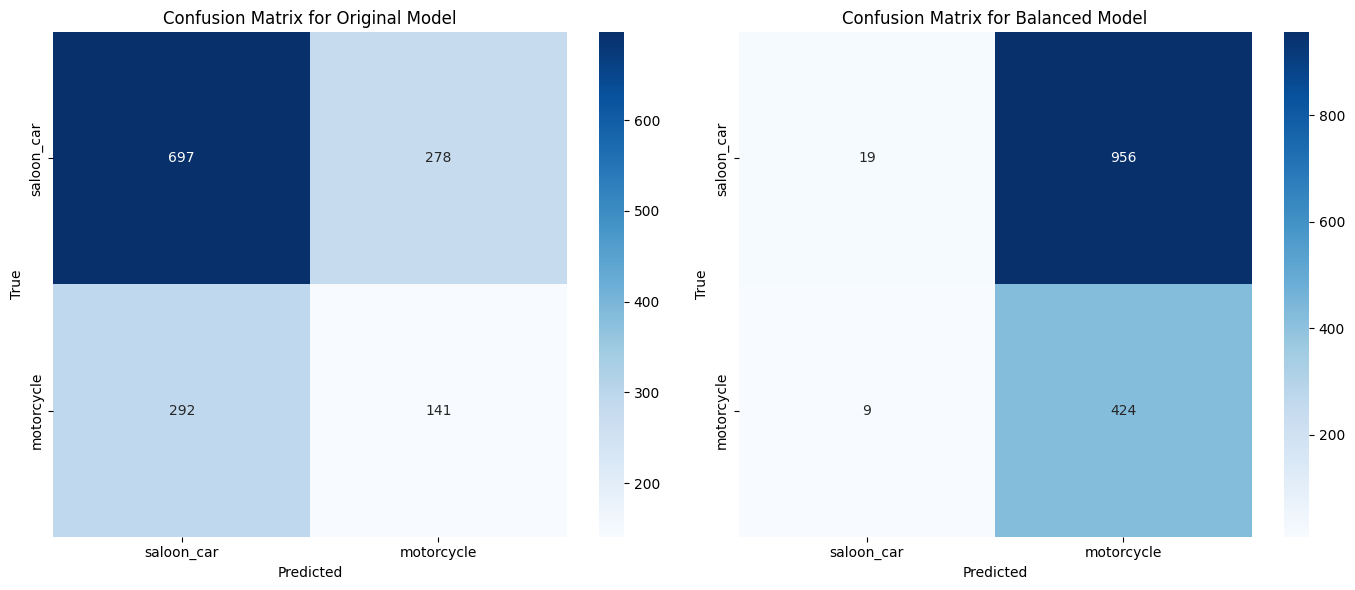

In [13]:
cm_original = confusion_matrix(true_classes, predicted_classes_original)
cm_balanced = confusion_matrix(true_classes, predicted_classes_balanced)


report_original = classification_report(true_classes, predicted_classes_original, target_names=['saloon_car', 'motorcycle'])
report_balanced = classification_report(true_classes, predicted_classes_balanced, target_names=['saloon_car', 'motorcycle'])


fpr_original, tpr_original, _ = roc_curve(true_classes, predictions_original)
roc_auc_original = auc(fpr_original, tpr_original)

fpr_balanced, tpr_balanced, _ = roc_curve(true_classes, predictions_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', xticklabels=['saloon_car', 'motorcycle'], yticklabels=['saloon_car', 'motorcycle'])
plt.title('Confusion Matrix for Original Model')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=['saloon_car', 'motorcycle'], yticklabels=['saloon_car', 'motorcycle'])
plt.title('Confusion Matrix for Balanced Model')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()



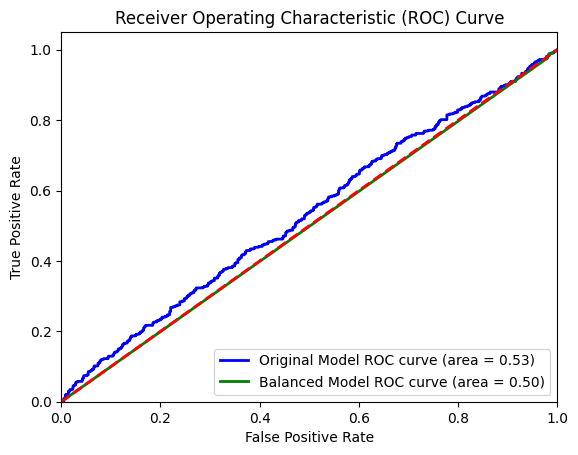

In [14]:

plt.figure()
plt.plot(fpr_original, tpr_original, color='blue', lw=2, label='Original Model ROC curve (area = %0.2f)' % roc_auc_original)
plt.plot(fpr_balanced, tpr_balanced, color='green', lw=2, label='Balanced Model ROC curve (area = %0.2f)' % roc_auc_balanced)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [ ]:
print("Classification Report for Original Model")
print(report_original)
print("\nClassification Report for Balanced Model")
print(report_balanced)
